In [9]:
import math
import numpy
from gnuradio import gr, digital
from gnuradio import analog
from gnuradio import blocks
import sys
from ITpp import BCH_Encoder, BCH_Decoder, RS_Encoder, RS_Decoder


try:
    from scipy.special import comb
    from scipy.special import erfc
except ImportError:
    print "Error: could not import scipy (http://www.scipy.org/)"
    sys.exit(1)

try:
    import pylab
except ImportError:
    print "Error: could not import pylab (http://matplotlib.sourceforge.net/)"
    sys.exit(1)

# Best to choose powers of 10
#N_BITS = 1e7
N_BITS = 1e7
RAND_SEED = 42

In [10]:
def Q(x):
    return (0.5 * erfc(x/(numpy.sqrt(2))))

def Pb_BPSK(EbN0):
    return Q(numpy.sqrt(2*EbN0))

def Pb_DBPSK(EbN0):
    return 2 * Q(numpy.sqrt(2*EbN0)) - 2 * Q(numpy.sqrt(2*EbN0))**2

def from_dB(x):
    return math.pow(10, x/10)

def Pb_Hard_Codes(p, N, t):
    Sum = 0
    for m in range(t+1, N + 1):
        x = (m + t) * comb(N, m, exact = True, repetition = False) * p ** (m) * (1 - p) ** (N - m)
        Sum += x
    return Sum/N

def berawgn_BPSK(EbN0):
    """ Calculates theoretical bit error rate in AWGN (for BPSK and given Eb/N0) """
    return Pb_BPSK(from_dB(EbN0))

def berawgn_DBPSK(EbN0):
    """ Calculates theoretical bit error rate in AWGN (for DBPSK and given Eb/N0) """
    return Pb_DBPSK(from_dB(EbN0))


class BitErrors(gr.hier_block2):
    """ Two inputs: true and received bits. We compare them and
    add up the number of incorrect bits. Because integrate_ff()
    can only add up a certain number of values, the output is
    not a scalar, but a sequence of values, the sum of which is
    the BER. """
    def __init__(self, bits_per_byte):
        gr.hier_block2.__init__(self, "BitErrors",
                gr.io_signature(2, 2, gr.sizeof_char),
                gr.io_signature(1, 1, gr.sizeof_int))

        # Bit comparison
        comp = blocks.xor_bb()
        intdump_decim = 100000

	#print(bits_per_byte)

        if N_BITS < intdump_decim:
            intdump_decim = int(N_BITS)
        self.connect(self,
                     comp,
                     blocks.unpack_k_bits_bb(bits_per_byte),
                     blocks.uchar_to_float(),
                     blocks.integrate_ff(intdump_decim),
                     blocks.multiply_const_ff(1.0/N_BITS),
                     self)
        self.connect((self, 1), (comp, 1))

In [24]:
berawgn_BPSK(6.0)

0.002388290780932807

In [11]:
class BERAWGNSimu(gr.top_block):
    " This contains the simulation flow graph "
    def __init__(self, EbN0):
        gr.top_block.__init__(self)
        self.const = digital.bpsk_constellation()
        # Source is N_BITS bits, non-repeated

        #print("BITS PER SYMBOL: ", self.const.bits_per_symbol())
        #print("arity: ", self.const.arity())

        data = map(int, numpy.random.randint(0, self.const.arity(), int(N_BITS/self.const.bits_per_symbol())))
        src   = blocks.vector_source_b(data, False)
        enc   = RS_Encoder(8, 11)
        mod   = digital.chunks_to_symbols_bc((self.const.points()), 1)
        add   = blocks.add_vcc()

        #print("Gaussian amplitude: ", self.EbN0_to_noise_voltage(EbN0))

        noise = analog.noise_source_c(analog.GR_GAUSSIAN,
                                      self.EbN0_to_noise_voltage(EbN0),
                                      RAND_SEED)
        demod = digital.constellation_decoder_cb(self.const.base())
        dec   = RS_Decoder(8, 11)
        ber   = BitErrors(self.const.bits_per_symbol())
        self.sink  = blocks.vector_sink_f()
        self.connect(src, enc, mod, add, demod, dec, ber, self.sink)
        self.connect(noise, (add, 1))
        self.connect(src, (ber, 1))

    def EbN0_to_noise_voltage(self, EbN0):
        """ Converts Eb/N0 to a complex noise voltage (assuming unit symbol power) """
        #print("BITS PER SYMBOL: ", self.const.bits_per_symbol())
        return 1.0 / math.sqrt(self.const.bits_per_symbol() * 10**(float(EbN0-10*math.log10(2040.0/1864.0))/10))

In [12]:
def simulate_ber(EbN0):
    """ All the work's done here: create flow graph, run, read out BER """
    print "Eb/N0 = {} dB".format(EbN0)
    fg = BERAWGNSimu(EbN0)
    fg.run()
    res = numpy.sum(fg.sink.data())
    print("BER: {}\n".format(res))
    return res

In [13]:
EbN0_min = 0
EbN0_max = 10
EbN0_range = range(EbN0_min, EbN0_max+1)
#EbN0_range = [0.5*x for x in range(EbN0_min*2, (EbN0_max+1)*2)]

In [14]:
ber_simu = [simulate_ber(x) for x in EbN0_range]

Eb/N0 = 0 dB
BER: 0.499571087305

Eb/N0 = 1 dB
BER: 0.499563577352

Eb/N0 = 2 dB
BER: 0.499497256824

Eb/N0 = 3 dB
BER: 0.499565346341

Eb/N0 = 4 dB
BER: 0.499475447315

Eb/N0 = 5 dB
BER: 0.440852787695

Eb/N0 = 6 dB
BER: 0.0258000298243

Eb/N0 = 7 dB
BER: 3.72300009985e-05

Eb/N0 = 8 dB
BER: 0.0

Eb/N0 = 9 dB
BER: 0.0

Eb/N0 = 10 dB
BER: 0.0



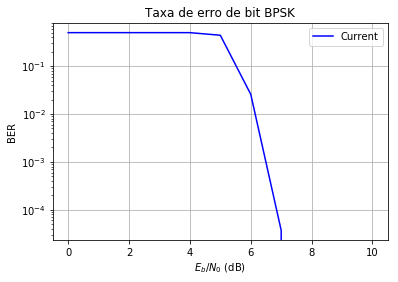

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.semilogy(EbN0_range, ber_simu, "b-", label = "Current")

plt.legend()
plt.title("Taxa de erro de bit BPSK")
plt.xlabel("$E_b/N_0$ (dB)")
plt.ylabel("BER")
plt.grid()

In [16]:
#
np.save("bpsk_reed_solomon_m8_t11.npy", ber_simu)